In [1]:
import gc
import os
import random
import sys
import time
import math

import nltk
import torch.nn as nn

import pandas as pd
import torch
from PIL import Image
from nltk.corpus import wordnet
from sklearn.feature_extraction.text import TfidfVectorizer
from torch import optim
from torch.optim.lr_scheduler import ExponentialLR, StepLR
from torchvision import transforms
import re
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm
import warnings
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import torch.nn.functional as F
from collections import defaultdict
from itertools import product
from textblob import TextBlob

warnings.filterwarnings("ignore", category=UserWarning)  # Disable UserWarnings
tqdm.pandas()

In [2]:
train_df = pd.read_csv("./dataset/train.csv")
test_df = pd.read_csv("./dataset/test.csv")
validation_df = pd.read_csv("./dataset/val.csv")

In [3]:
import text_preprocessing

train_df['preprocessed_text'] = train_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)
validation_df['preprocessed_text'] = validation_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)
test_df['preprocessed_text'] = test_df['caption'].progress_apply(text_preprocessing.text_preparetion_simple)

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\allex\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


a world war iiera bomber flying out of formation
a domesticated carnivorous mammal that typically haas a long snout an acute sense off smell <unk> claws and barking y howling or whining voice


100%|██████████| 2000/2000 [00:00<00:00, 394739.45it/s]


In [4]:
train_df

,id,caption,image_id,label,preprocessed_text
0,417812c5-0ce4-499d-b97d-4d28827239bc,Wet elephants shake water onto people bathing ...,394330,0,wet elephants shake water onto people bathing ...
1,5ac91fa3-55f2-4cb3-8c8f-ad84f78e6b36,Two men holding tennis racquets on the court,130849,0,two men holding tennis racquets on the court
2,d2705b90-8347-4cab-a7a6-654540d9a489,A bird on a tree limb with mountains in the ba...,514790,0,a bird on a tree limb with mountains in the ba...
3,a3b33fe7-3085-4433-9c18-8814803891b4,A kitchen and dining room are featured along w...,182096,0,a kitchen and dining room are featured along w...
4,1514b0e4-0665-45bc-ab32-52fce326cc29,A fruit stand has various fruits on the table.,68788,1,a fruit stand has various fruits on the table
...,...,...,...,...,...
9995,1d1df243-485d-4b29-82c8-7e34c0de1f5c,Several people stand in a field flying a kite.,522702,0,several people stand in a field flying a kite
9996,f7dfa883-e524-4974-b5ba-6b3c3db49087,A batter hitting a pitch at a baseball game.,441874,1,a batter hitting a pitch at a baseball game
9997,602e83dc-6539-4c1a-8d19-c1481b5c24bf,A person on white surfboard next to group in a...,166716,0,a person on white surfboard next to group in a...
9998,d9ce2e8c-0831-466a-8756-4c40d772b1ce,A baseball player getting ready to swing at th...,517601,0,a baseball player getting ready to swing at th...


In [5]:
def build_simple_vocab(sentences, special_tokens=None):
    """
    Manually create a vocabulary from a list of tokenized sentences.
    
    Args:
        sentences (list of str): List of sentences to build vocabulary from.
        special_tokens (list of str): Special tokens like <pad>, <unk>.
        
    Returns:
        dict: A vocabulary mapping tokens to indices.
        dict: An inverse vocabulary mapping indices to tokens.
    """
    special_tokens = special_tokens or ['<pad>', '<unk>']
    vocab = defaultdict(lambda: len(vocab))  # Default index is the current vocab size
    for token in special_tokens:
        vocab[token]  # Add special tokens first

    # Add tokens from sentences
    for sentence in sentences:
        for token in nltk.word_tokenize(sentence):
            if token.strip():  # Exclude empty tokens
                vocab[token]

    # Convert to a normal dict (no longer dynamic)
    vocab = dict(vocab)
    inverse_vocab = {index: token for token, index in vocab.items()}
    return vocab, inverse_vocab


# Vectorize a sentence
def vectorize_sentence(sentence, vocab):
    """
    Converts a sentence into a tensor of token indices using a given vocabulary,
    ignoring empty tokens.
    
    Args:
        sentence (str): Input sentence.
        vocab (Vocab): Vocabulary to map tokens to indices.
        
    Returns:
        torch.Tensor: Vectorized sentence as a tensor.
    """
    # Ensure '<unk>' exists in the vocabulary
    unk_idx = vocab.get('<unk>', -1)
    if unk_idx == -1:
        raise ValueError("The vocabulary must include '<unk>' for unknown tokens.")

    # Split sentence into tokens and map them to indices
    tokens = [token for token in sentence.split() if token.strip()]
    return torch.tensor([vocab.get(token, unk_idx) for token in tokens], dtype=torch.long)



# Custom Dataset Class
class PreprocessingDataset(Dataset):
    def __init__(self, dataframe, vocab, images_path, train=True, max_len=None, augmentation_prob=0.3):
        """
        Dataset for preprocessing image-text pairs with TF-IDF vectorization.

        Args:
            dataframe (pd.DataFrame): DataFrame containing 'image_id', 'sentence', and optionally 'label'.
            vectorizer (TfidfVectorizer): TF-IDF vectorizer for text.
            images_path (str): Base path to the images.
            train (bool): Whether this is a training dataset.
            max_len (int): Maximum length for sentences in terms of features. Truncation isn't typical with TF-IDF.
        """
        super().__init__()
        self.dataframe = dataframe
        self.vocab = vocab
        self.train = train
        self.max_len = max_len
        self.images_path = images_path
        self.augmentation_prob = augmentation_prob
        # Define image transformations
        self.image_transform = transforms.Compose([
            transforms.RandomResizedCrop(100, scale=(0.8, 1.0)),
            # transforms.RandomVerticalFlip(),
            transforms.RandomHorizontalFlip(),
            transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ])

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]

        # Process sentence
        sentence = row['caption']
        if random.random() < self.augmentation_prob:
            # sentence = self.augment_text(sentence)
            sentence = self.synonym_replacement(sentence)
        vectorized_sentence = vectorize_sentence(sentence, self.vocab)

        # Pad or truncate the sentence
        if len(vectorized_sentence) < self.max_len:
            padding_length = self.max_len - len(vectorized_sentence)
            pad_tensor = torch.full((padding_length,), self.vocab['<pad>'], dtype=torch.long)
            vectorized_sentence = torch.cat((vectorized_sentence, pad_tensor), dim=0)
        else:
            vectorized_sentence = vectorized_sentence[:self.max_len]

        # Process image
        image_path = f"{self.images_path}{row['image_id']}.jpg"
            
        try:
            image = Image.open(image_path).convert("RGB")  # Convert to RGB
            image = self.image_transform(image)
        except FileNotFoundError:
            raise FileNotFoundError(f"Image not found at path: {image_path}")

        # Handle labels (for training)
        if self.train:
            label = row['label']
            label = torch.tensor(label, dtype=torch.long)
            return {
                'images': image,
                'captions': vectorized_sentence,
                'labels': label
            }
        else:
            return {
                'images': image,
                'captions': vectorized_sentence,
                'id': row['id']
            }

    def augment_text(self, text):
        """ Augment text using synonym replacement and rephrasing. """
        if random.random() < 0.5:
            return self.synonym_replacement(text)
        else:
            return self.rephrase_text(text)


    def synonym_replacement(self, text):
        # Tokenize the sentence
        words = nltk.word_tokenize(text)
        new_words = words.copy()
    
        # Find indices of words that can be replaced
        replaceable = [i for i, word in enumerate(words) if wordnet.synsets(word)]
        
        # Randomly choose half of these words to replace
        num_to_replace = len(replaceable) // 2
        chosen_indices = random.sample(replaceable, num_to_replace)
    
        # Replace chosen words with synonyms
        for i in chosen_indices:
            synsets = wordnet.synsets(words[i])
            if synsets:
                # Choose a random synonym from the first synset
                synonyms = list(set([lemma.name() for lemma in synsets[0].lemmas() if lemma.name() != words[i]]))
                if synonyms:
                    new_words[i] = random.choice(synonyms).replace('_', ' ')

        # Reconstruct the sentence
        return ' '.join(new_words)


    def rephrase_text(self, text):
        blob = TextBlob(text)
        return str(blob.correct())

In [6]:
tokenized_sentence = [nltk.word_tokenize(sentence) for sentence in train_df['preprocessed_text']]
max_len = max(len([token for token in sentence.split(" ")]) for sentence in train_df['preprocessed_text'])
print(max_len)
vocab, inverse_vocab = build_simple_vocab(train_df['preprocessed_text'])

46


In [7]:
vocab

{'<pad>': 0,
 '<unk>': 1,
 'wet': 2,
 'elephants': 3,
 'shake': 4,
 'water': 5,
 'onto': 6,
 'people': 7,
 'bathing': 8,
 'them': 9,
 'two': 10,
 'men': 11,
 'holding': 12,
 'tennis': 13,
 'racquets': 14,
 'on': 15,
 'the': 16,
 'court': 17,
 'a': 18,
 'bird': 19,
 'tree': 20,
 'limb': 21,
 'with': 22,
 'mountains': 23,
 'in': 24,
 'background': 25,
 'kitchen': 26,
 'and': 27,
 'dining': 28,
 'room': 29,
 'are': 30,
 'featured': 31,
 'along': 32,
 'large': 33,
 'table': 34,
 'appliances': 35,
 'chandelier': 36,
 'fruit': 37,
 'stand': 38,
 'has': 39,
 'various': 40,
 'fruits': 41,
 'baseball': 42,
 'athlete': 43,
 'getting': 44,
 'ready': 45,
 'to': 46,
 'swing': 47,
 'bat': 48,
 'player': 49,
 'is': 50,
 'swinging': 51,
 'at': 52,
 'game': 53,
 'several': 54,
 'standing': 55,
 'front': 56,
 'of': 57,
 'tv': 58,
 'monitors': 59,
 'playing': 60,
 'wii': 61,
 'games': 62,
 'baby': 63,
 'lamb': 64,
 'feeds': 65,
 'open': 66,
 'field': 67,
 'as': 68,
 'mother': 69,
 'peers': 70,
 'forward'

In [8]:
train_dataset = PreprocessingDataset(train_df, vocab, images_path = "./dataset/train_images/", train=True, max_len=max_len)
val_dataset = PreprocessingDataset(validation_df, vocab, images_path = "./dataset/val_images/", train=True, max_len=max_len)
test_dataset = PreprocessingDataset(test_df, vocab, images_path = "./dataset/test_images/", train=False, max_len=max_len)

In [9]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [10]:
batch = next(iter(train_dataloader))
images = batch['images']
captions = batch['captions']
print(images.shape)
print(captions.shape)
print(captions[0])

torch.Size([32, 3, 100, 100])
torch.Size([32, 46])
tensor([   1,  718, 2040,   24, 2041,   24,   18, 2042,  760,    1,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0])


In [11]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
class SEBlock(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [13]:
class CNN(nn.Module):
    def __init__(self, cnn_dropout_value):
        super(CNN, self).__init__()
        

        self.CNN_block = nn.Sequential(
            self.CNN2d_block(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN2d_block(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN2d_block(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN2d_block(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            

            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm2d(128),
            nn.Dropout(cnn_dropout_value),
            SEBlock(128),
            nn.AdaptiveAvgPool2d((1, 1))
        )
        self.flatten = nn.Flatten()

    def forward(self, images):
        img_features = self.CNN_block(images)  
        img_features = self.flatten(img_features)  
        return img_features
    
    def CNN2d_block(self, in_channels, out_channels, kernel_size, stride, padding, cnn_dropout_value):
        return nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Dropout(cnn_dropout_value),
            SEBlock(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        

In [14]:
class SEBlock1D(nn.Module):
    def __init__(self, channel, reduction=16):
        super(SEBlock1D, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.LeakyReLU(),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1)
        return x * y.expand_as(x)

In [15]:
class PositionalEncoding(nn.Module):
    def __init__(self, embedding_dim, max_len):
        super(PositionalEncoding, self).__init__()
        # Create a matrix of shape (max_len, embedding_dim) for positional encodings
        position = torch.arange(0, max_len).unsqueeze(1)  # Shape: (max_len, 1)
        div_term = torch.exp(torch.arange(0, embedding_dim, 2) * (-math.log(float(max_len)) / embedding_dim))
        
        pe = torch.zeros(max_len, embedding_dim)  # Shape: (max_len, embedding_dim)
        pe[:, 0::2] = torch.sin(position * div_term)  # Sin for even indices
        pe[:, 1::2] = torch.cos(position * div_term)  # Cos for odd indices
        
        pe = pe.unsqueeze(0)  # Add batch dimension: (1, max_len, embedding_dim)
        self.register_buffer('pe', pe)  # Register as non-learnable buffer

    def forward(self, x):
        """
        Add positional encoding to the input embeddings.
        x: (Batch, SeqLen, EmbeddingDim)
        """
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :].to(x.device)

In [16]:
class TextModule(nn.Module):
    def __init__(self, cnn_dropout_value, vocab_size, embedding_dim=32):
        super(TextModule, self).__init__()

        self.embedding = nn.Embedding(num_embeddings=vocab_size, embedding_dim=embedding_dim, padding_idx=vocab["<pad>"])
        self.positional_encoding = PositionalEncoding(embedding_dim=embedding_dim, max_len=max_len)
        

        self.CNN1d = nn.Sequential(
            self.CNN1d_block(in_channels=embedding_dim, out_channels=32, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN1d_block(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),
            self.CNN1d_block(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1, cnn_dropout_value=cnn_dropout_value),

            nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(),
            nn.BatchNorm1d(128),
            nn.Dropout(cnn_dropout_value),
            SEBlock1D(128),
            nn.AdaptiveAvgPool1d(1)
        )
        self.flatten = nn.Flatten()

    def forward(self, captions):
        text_features = self.embedding(captions)
        text_features = self.positional_encoding(text_features).permute(0, 2, 1)
        text_features = self.CNN1d(text_features)  # 
        text_features = self.flatten(text_features)  # 
        return text_features
    
    def CNN1d_block(self, in_channels, out_channels, kernel_size, stride, padding, cnn_dropout_value):
        return nn.Sequential(
            nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=stride, padding=padding),
            nn.LeakyReLU(),
            nn.BatchNorm1d(out_channels),
            nn.Dropout(cnn_dropout_value),
            SEBlock1D(out_channels),
            nn.MaxPool1d(kernel_size=2, stride=2)
        )

In [17]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=1.0, eps=1e-9):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin
        self.eps = eps  # small epsilon for numerical stability

    def forward(self, img_emb, text_emb, labels):
        # Calculate the Euclidean distance between each pair of image and text embeddings
        distances = (img_emb - text_emb).pow(2).sum(1).sqrt() + self.eps
        
        # Contrastive loss calculation
        loss = 0.5 * (labels * distances.pow(2) + 
                      (1 - labels) * torch.clamp(self.margin - distances, min=0.0).pow(2))
        
        return loss.mean()


In [18]:
class ContrastiveLossCosine(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLossCosine, self).__init__()
        self.margin = margin

    def forward(self, img_emb, text_emb, labels):
        # Normalize embeddings to unit vectors
        img_emb = F.normalize(img_emb, p=2, dim=1)
        text_emb = F.normalize(text_emb, p=2, dim=1)

        # Cosine similarity
        cosine_sim = (img_emb * text_emb).sum(1)

        # Contrastive loss with cosine similarity
        loss = 0.5 * (labels * (1 - cosine_sim).pow(2) + 
                      (1 - labels) * torch.clamp(cosine_sim - self.margin, min=0.0).pow(2))
        return loss.mean()


In [19]:
def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Conv2d) or isinstance(m, nn.Conv1d):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)
    elif isinstance(m, nn.Embedding):
        nn.init.xavier_uniform_(m.weight)
    elif isinstance(m, nn.LayerNorm):
        nn.init.ones_(m.weight)
        nn.init.zeros_(m.bias)
    elif isinstance(m, nn.TransformerEncoderLayer):
        for name, param in m.named_parameters():
            if "weight" in name:
                if param.dim() > 1:
                    nn.init.xavier_uniform_(param)
                else:
                    nn.init.ones_(param)
            elif "bias" in name:
                nn.init.zeros_(param)

In [20]:
# Initialize the model
model_config = {
    "cnn_dropout_value": 0.25,
    "vocab_size":len(vocab),
}

image_model = CNN(model_config["cnn_dropout_value"])
text_model = TextModule(model_config["cnn_dropout_value"], len(vocab))
margin = 0.25
criterion = ContrastiveLoss(margin=margin)
image_model.apply(initialize_weights)
text_model.apply(initialize_weights)
image_model.to(device)
text_model.to(device)


# test modules
dummy_images = torch.randn(16, 3, 100, 100).to(device)
dummy_texts = torch.randint(0, len(vocab), (16, max_len)).to(device)
print(image_model(dummy_images).shape)
print(text_model(dummy_texts).shape)

torch.Size([16, 128])
torch.Size([16, 128])


In [21]:
optimizer = torch.optim.Adam(list(image_model.parameters()) + list(text_model.parameters()),  lr=3e-5, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
    optimizer,
    T_0=10,  # Number of epochs before the first restart
    T_mult=1,  # Multiplicative factor for increasing restart period
    eta_min=1e-5  # Minimum learning rate
)

In [22]:
def analyze_distance_distributions(distances, labels):
    """
    Analyze and plot the distance distributions for matching and non-matching pairs.

    Args:
        distances: List of distances between image and text embeddings.
        labels: List of ground truth labels (1 for match, 0 for non-match).
    """
    import numpy as np
    distances = np.array(distances)
    labels = np.array(labels)

    matching_distances = distances[labels == 1]
    non_matching_distances = distances[labels == 0]

    # Plot the distributions
    plt.hist(matching_distances, bins=50, alpha=0.5, label="Matching Pairs", color="blue")
    plt.hist(non_matching_distances, bins=50, alpha=0.5, label="Non-Matching Pairs", color="orange")
    plt.axvline(x=0.5, color='r', linestyle='--', label="Threshold (0.5)")
    plt.title("Distance Distributions")
    plt.xlabel("Distance")
    plt.ylabel("Frequency")
    plt.legend()
    plt.grid()
    plt.show()

    # Print summary statistics
    print(f"Matching Pairs: Mean = {np.mean(matching_distances):.4f}, Std = {np.std(matching_distances):.4f}")
    print(f"Non-Matching Pairs: Mean = {np.mean(non_matching_distances):.4f}, Std = {np.std(non_matching_distances):.4f}")

In [23]:
import numpy as np
import copy


def training_method(criterion, optimizer, scheduler, num_epochs, train_loader, val_loader, patience=5, delta=0.05, loss_procentage_improvement=10):
    train_losses = []  # List to store training losses
    val_losses = []  # List to store validation losses
    val_accuracies = []  # List to store validation accuracies
    val_precisions = []  # List to store validation precisions
    val_recalls = []  # List to store validation recalls
    val_f1s = []  # List to store validation F1-scores
    learning_rates = []  # List to store learning rate progression

    best_val_loss = float('inf')  # Initialize the best validation loss
    initial_loss = float('inf')
    best_text_model = None
    best_image_model = None
    epochs_without_improvement = 0  # Track epochs without improvement

    for epoch in range(num_epochs):
        start_time = time.time()
        all_distances = []

        ### TRAINING
        image_model.train()
        text_model.train()
        training_loss = 0.0
        for batch in train_loader:
            images = batch['images'].to(device)  # Images from batch
            captions = batch['captions'].to(device)  # Captions from batch
            labels = batch['labels'].to(device).float()  # Binary labels (0/1), converted to float

            # Forward pass
            img_features = image_model(images)
            txt_features = text_model(captions)
            loss = criterion(img_features, txt_features, labels)
    
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            training_loss += loss.item() * images.size(0)  # Accumulate loss

        train_loss = training_loss / len(train_loader.dataset)  # Average training loss
        train_losses.append(train_loss)

        ### VALIDATING
        image_model.eval()
        text_model.eval()
        validation_loss = 0.0
        all_labels = []  # Ground truth labels for validation
        all_preds = []  # Predictions for validation

        with torch.no_grad():
            for batch in val_loader:
                images = batch['images'].to(device)
                captions = batch['captions'].to(device)
                labels = batch['labels'].to(device).float()

                # Forward pass
                img_features = image_model(images)
                txt_features = text_model(captions)
                loss = criterion(img_features, txt_features, labels)
                validation_loss += loss.item() * images.size(0)
                # Compute distances and predictions
                distances = torch.norm(img_features - txt_features, p=2, dim=1)
                preds = (distances < 0.5).float()


                # Store for statistics
                all_labels.extend(labels.cpu().numpy())
                all_preds.extend(preds.cpu().numpy())
                all_distances.extend(distances.cpu().numpy())
                
        print(f"{sum(all_preds)=}")
        
        analyze_distance_distributions(all_distances, all_labels)
        
        val_loss = validation_loss / len(val_loader.dataset)  # Average validation loss
        val_losses.append(val_loss)

        # Compute validation statistics
        val_accuracy = accuracy_score(all_labels, all_preds)
        val_precision = precision_score(all_labels, all_preds, zero_division=0)
        val_recall = recall_score(all_labels, all_preds, zero_division=0)
        val_f1 = f1_score(all_labels, all_preds, zero_division=0)

        val_accuracies.append(val_accuracy)
        val_precisions.append(val_precision)
        val_recalls.append(val_recall)
        val_f1s.append(val_f1)

        # Step the learning rate scheduler
        scheduler.step()
        current_lr = optimizer.param_groups[0]['lr']  # Get the current learning rate
        learning_rates.append(current_lr)
        end_time = time.time()

        print(f"\nEpoch {epoch + 1}/{num_epochs} - "
              f"Training Loss: {train_loss:.4f} - "
              f"Validation Loss: {val_loss:.4f} - "
              f"Accuracy: {val_accuracy:.4f} - "
              f"Precision: {val_precision:.4f} - "
              f"Recall: {val_recall:.4f} - "
              f"F1 Score: {val_f1:.4f} - "
              f"Time: {end_time - start_time:.2f} - "
              f"Lr: {current_lr:.2e}")

        if epoch == 1:
            initial_loss = val_loss

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_text_model = copy.deepcopy(text_model)
            best_image_model = copy.deepcopy(image_model)
            epochs_without_improvement = 0  # Reset counter
            print(f"New best model with Loss: {val_loss:.4f} at epoch {epoch + 1}")
        elif val_loss < best_val_loss + delta:
            print(f"Validation loss did not improve significantly")
        else:
            epochs_without_improvement += 1
            print(f"Validation loss did not improve for {epochs_without_improvement} epoch(s).")
            # Stop training if validation loss does not improve for 'patience' epochs
            if epochs_without_improvement >= patience:
                print(f"Early stopping at epoch {epoch + 1}. Best Loss: {best_val_loss:.4f}")
                break  # Exit training loop

    print('Training finished!')

    # save the model only if the best loss is lower than the first initial loss ( to see that the model actually improved with 10% loss )
    if best_val_loss < (100 - loss_procentage_improvement) * initial_loss:
        # Init plot&model save path
        # plt_save_path = "models/"
        # model_config['eval_loss'] = best_val_loss
        # for key, value in model_config.items():
        #     plt_save_path += key + "=" + str(value) + "+"
        # plt_save_path = plt_save_path[:-1] + ".png"
        # model_path = plt_save_path[:-4] + ".pt"
        # torch.save(best_model.state_dict(), model_path)
        # print(f"Best model with Loss: {best_val_loss:.4f} saved.")
        # print(f"Model saved to {model_path}")

        # Plotting the losses and validation metrics over epochs
        plt.figure(figsize=(12, 8))
        plt.subplot(3, 1, 1)
        plt.plot(train_losses, label='Training Loss')
        plt.plot(val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.title('Training and Validation Loss')
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(val_accuracies, label='Accuracy')
        plt.plot(val_precisions, label='Precision')
        plt.plot(val_recalls, label='Recall')
        plt.plot(val_f1s, label='F1 Score')
        plt.xlabel('Epochs')
        plt.ylabel('Metric')
        plt.title('Validation Metrics')
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(learning_rates, label='Learning Rate')
        plt.xlabel("Epochs")
        plt.ylabel("Learning Rate")
        plt.title("Learning Rate Progression")
        plt.legend()

        plt.tight_layout()
        # plt.savefig(plt_save_path)
        plt.show()

    else:
        print(f"Model wasn't saved because it didn't improve: {loss_procentage_improvement}%")
    
    return best_text_model, best_image_model

sum(all_preds)=0.0


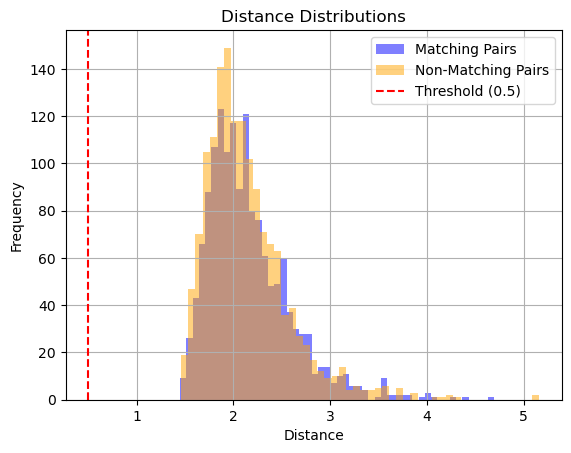

Matching Pairs: Mean = 2.1607, Std = 0.4329
Non-Matching Pairs: Mean = 2.1347, Std = 0.4352

Epoch 1/50 - Training Loss: 2.0112 - Validation Loss: 1.2140 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 27.10 - Lr: 2.95e-05
New best model with Loss: 1.2140 at epoch 1
sum(all_preds)=0.0


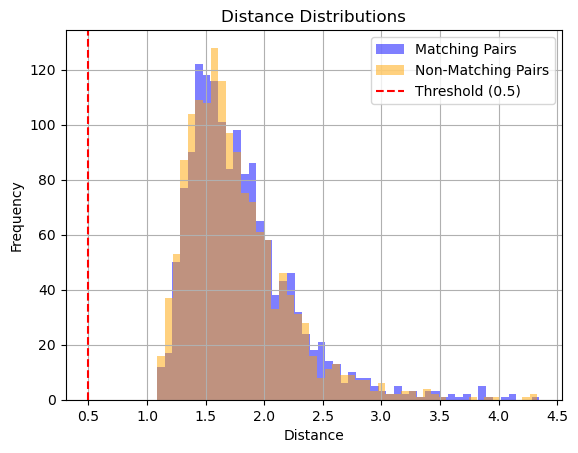

Matching Pairs: Mean = 1.8033, Std = 0.4619
Non-Matching Pairs: Mean = 1.7621, Std = 0.4338

Epoch 2/50 - Training Loss: 1.4077 - Validation Loss: 0.8663 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 24.70 - Lr: 2.81e-05
New best model with Loss: 0.8663 at epoch 2
sum(all_preds)=0.0


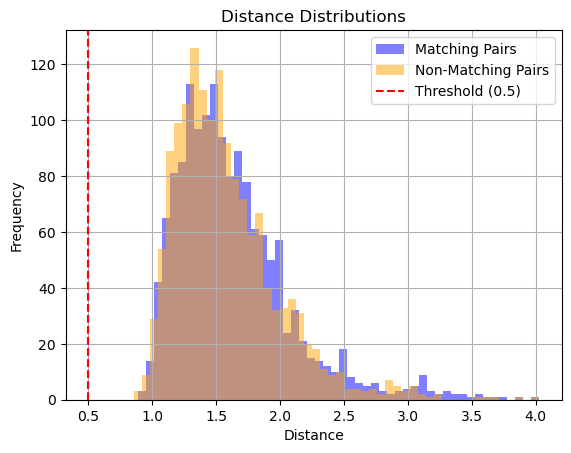

Matching Pairs: Mean = 1.6337, Std = 0.4565
Non-Matching Pairs: Mean = 1.5809, Std = 0.4135

Epoch 3/50 - Training Loss: 1.1223 - Validation Loss: 0.7194 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 24.97 - Lr: 2.59e-05
New best model with Loss: 0.7194 at epoch 3
sum(all_preds)=0.0


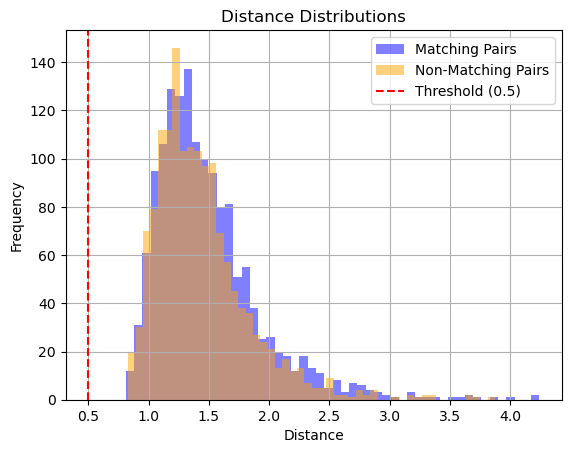

Matching Pairs: Mean = 1.4912, Std = 0.4434
Non-Matching Pairs: Mean = 1.4402, Std = 0.3980

Epoch 4/50 - Training Loss: 0.9793 - Validation Loss: 0.6051 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.15 - Lr: 2.31e-05
New best model with Loss: 0.6051 at epoch 4
sum(all_preds)=0.0


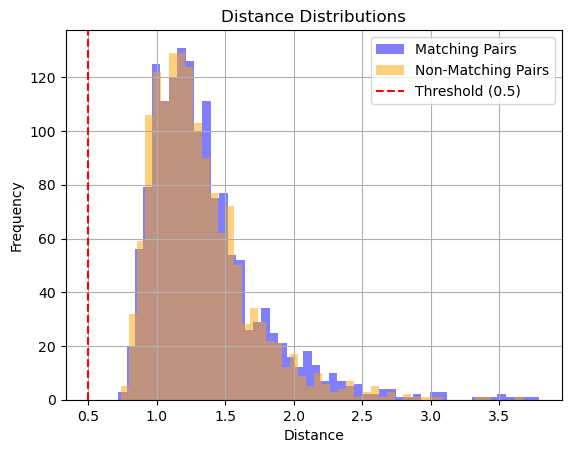

Matching Pairs: Mean = 1.3567, Std = 0.4167
Non-Matching Pairs: Mean = 1.3134, Std = 0.3630

Epoch 5/50 - Training Loss: 0.8970 - Validation Loss: 0.5035 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.15 - Lr: 2.00e-05
New best model with Loss: 0.5035 at epoch 5
sum(all_preds)=0.0


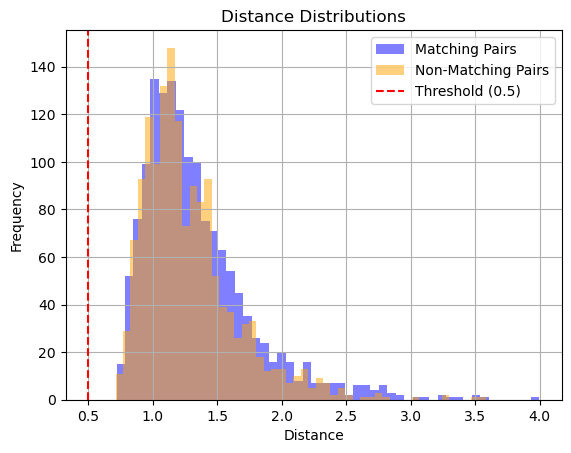

Matching Pairs: Mean = 1.3401, Std = 0.4298
Non-Matching Pairs: Mean = 1.2836, Std = 0.3686

Epoch 6/50 - Training Loss: 0.8497 - Validation Loss: 0.4952 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.17 - Lr: 1.69e-05
New best model with Loss: 0.4952 at epoch 6
sum(all_preds)=0.0


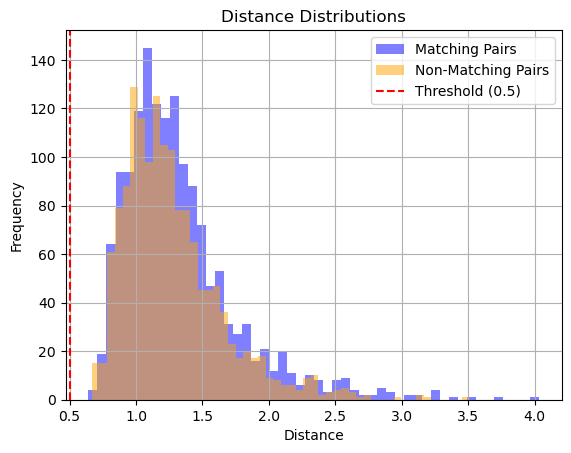

Matching Pairs: Mean = 1.3290, Std = 0.4372
Non-Matching Pairs: Mean = 1.2729, Std = 0.3757

Epoch 7/50 - Training Loss: 0.8129 - Validation Loss: 0.4894 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 24.91 - Lr: 1.41e-05
New best model with Loss: 0.4894 at epoch 7
sum(all_preds)=0.0


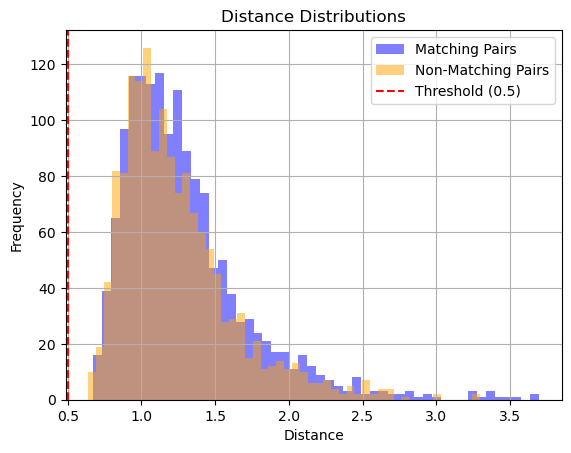

Matching Pairs: Mean = 1.2929, Std = 0.4330
Non-Matching Pairs: Mean = 1.2413, Std = 0.3835

Epoch 8/50 - Training Loss: 0.7827 - Validation Loss: 0.4648 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.08 - Lr: 1.19e-05
New best model with Loss: 0.4648 at epoch 8
sum(all_preds)=0.0


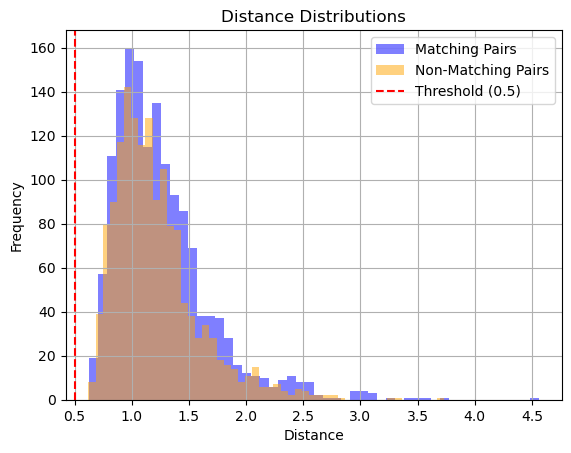

Matching Pairs: Mean = 1.2652, Std = 0.4345
Non-Matching Pairs: Mean = 1.2099, Std = 0.3769

Epoch 9/50 - Training Loss: 0.7617 - Validation Loss: 0.4474 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.12 - Lr: 1.05e-05
New best model with Loss: 0.4474 at epoch 9
sum(all_preds)=0.0


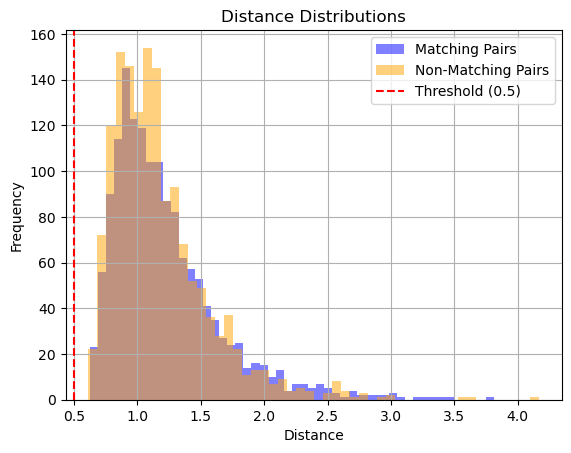

Matching Pairs: Mean = 1.2248, Std = 0.4356
Non-Matching Pairs: Mean = 1.1770, Std = 0.3931

Epoch 10/50 - Training Loss: 0.7448 - Validation Loss: 0.4225 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.00 - Lr: 3.00e-05
New best model with Loss: 0.4225 at epoch 10
sum(all_preds)=0.0


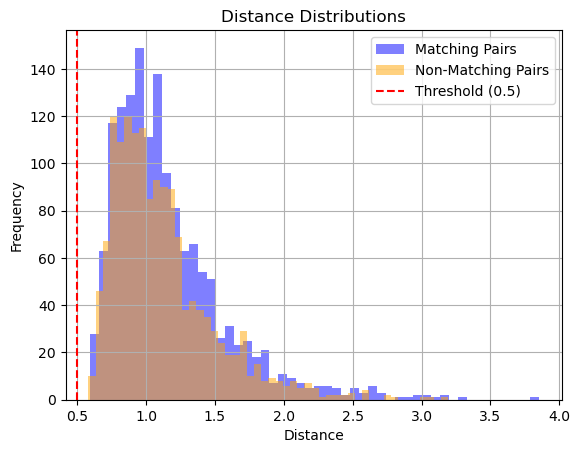

Matching Pairs: Mean = 1.1606, Std = 0.4202
Non-Matching Pairs: Mean = 1.1171, Std = 0.3700

Epoch 11/50 - Training Loss: 0.7144 - Validation Loss: 0.3809 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 24.99 - Lr: 2.95e-05
New best model with Loss: 0.3809 at epoch 11
sum(all_preds)=0.0


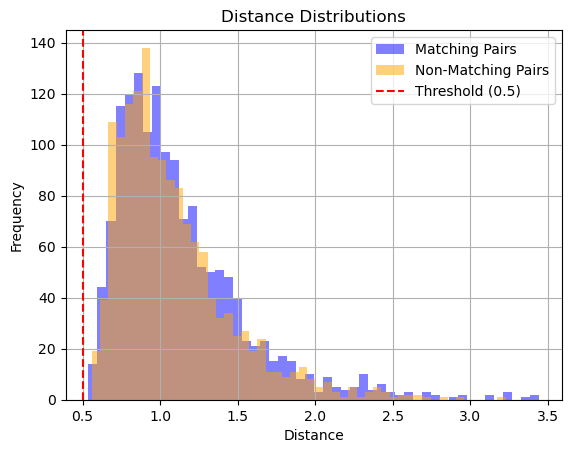

Matching Pairs: Mean = 1.1309, Std = 0.4287
Non-Matching Pairs: Mean = 1.0843, Std = 0.3737

Epoch 12/50 - Training Loss: 0.6775 - Validation Loss: 0.3657 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 24.96 - Lr: 2.81e-05
New best model with Loss: 0.3657 at epoch 12
sum(all_preds)=0.0


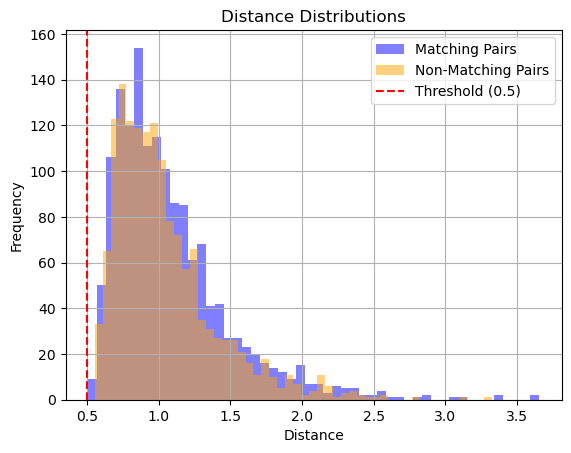

Matching Pairs: Mean = 1.0839, Std = 0.4096
Non-Matching Pairs: Mean = 1.0410, Std = 0.3623

Epoch 13/50 - Training Loss: 0.6421 - Validation Loss: 0.3356 - Accuracy: 0.5000 - Precision: 0.0000 - Recall: 0.0000 - F1 Score: 0.0000 - Time: 25.44 - Lr: 2.59e-05
New best model with Loss: 0.3356 at epoch 13
sum(all_preds)=4.0


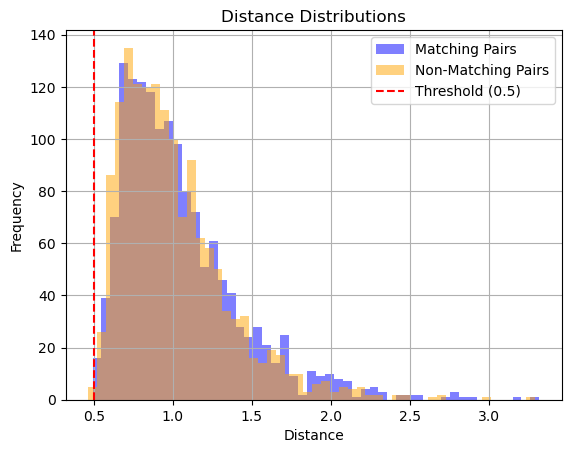

Matching Pairs: Mean = 1.0483, Std = 0.3842
Non-Matching Pairs: Mean = 1.0069, Std = 0.3496

Epoch 14/50 - Training Loss: 0.6081 - Validation Loss: 0.3117 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.0013 - F1 Score: 0.0027 - Time: 25.53 - Lr: 2.31e-05
New best model with Loss: 0.3117 at epoch 14
sum(all_preds)=7.0


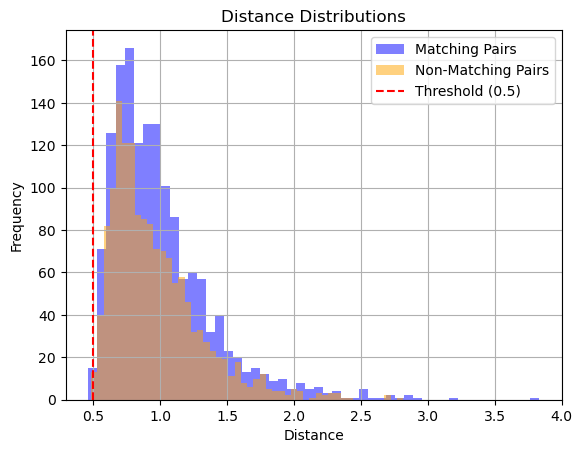

Matching Pairs: Mean = 1.0066, Std = 0.3876
Non-Matching Pairs: Mean = 0.9652, Std = 0.3366

Epoch 15/50 - Training Loss: 0.5784 - Validation Loss: 0.2909 - Accuracy: 0.5003 - Precision: 0.5714 - Recall: 0.0027 - F1 Score: 0.0053 - Time: 25.65 - Lr: 2.00e-05
New best model with Loss: 0.2909 at epoch 15
sum(all_preds)=17.0


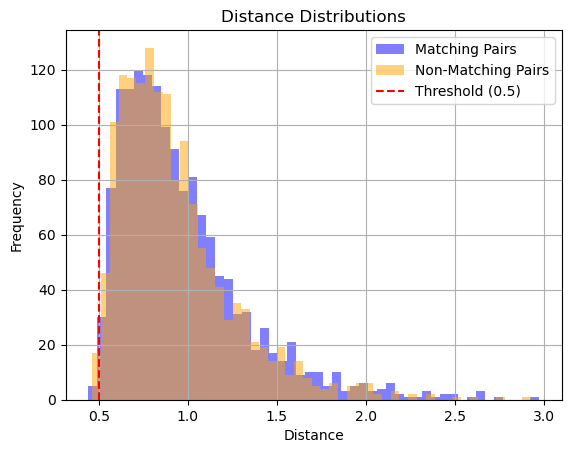

Matching Pairs: Mean = 0.9668, Std = 0.3612
Non-Matching Pairs: Mean = 0.9305, Std = 0.3229

Epoch 16/50 - Training Loss: 0.5465 - Validation Loss: 0.2663 - Accuracy: 0.4983 - Precision: 0.3529 - Recall: 0.0040 - F1 Score: 0.0079 - Time: 24.89 - Lr: 1.69e-05
New best model with Loss: 0.2663 at epoch 16
sum(all_preds)=33.0


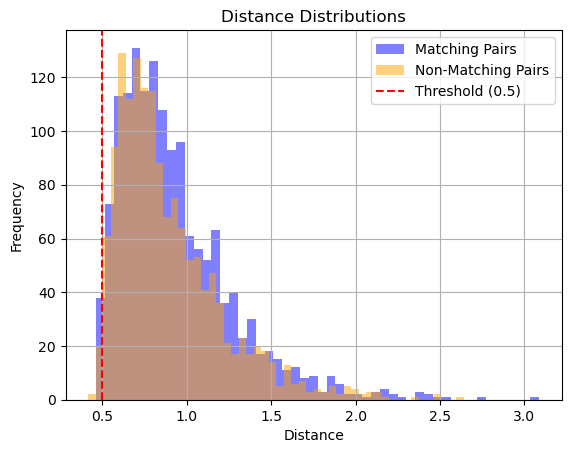

Matching Pairs: Mean = 0.9317, Std = 0.3424
Non-Matching Pairs: Mean = 0.8949, Std = 0.3173

Epoch 17/50 - Training Loss: 0.5202 - Validation Loss: 0.2463 - Accuracy: 0.4990 - Precision: 0.4545 - Recall: 0.0100 - F1 Score: 0.0196 - Time: 24.71 - Lr: 1.41e-05
New best model with Loss: 0.2463 at epoch 17
sum(all_preds)=66.0


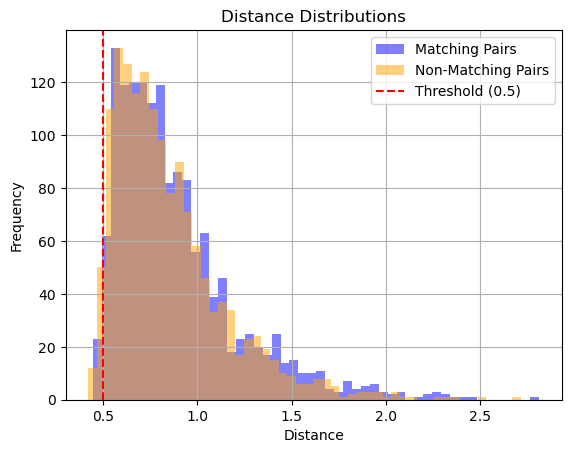

Matching Pairs: Mean = 0.8895, Std = 0.3323
Non-Matching Pairs: Mean = 0.8503, Std = 0.3031

Epoch 18/50 - Training Loss: 0.4972 - Validation Loss: 0.2254 - Accuracy: 0.4967 - Precision: 0.4242 - Recall: 0.0187 - F1 Score: 0.0358 - Time: 25.72 - Lr: 1.19e-05
New best model with Loss: 0.2254 at epoch 18
sum(all_preds)=103.0


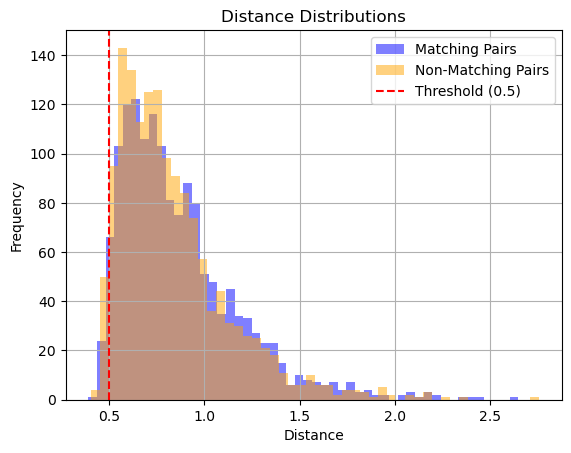

Matching Pairs: Mean = 0.8708, Std = 0.3147
Non-Matching Pairs: Mean = 0.8366, Std = 0.2964

Epoch 19/50 - Training Loss: 0.4750 - Validation Loss: 0.2143 - Accuracy: 0.4957 - Precision: 0.4369 - Recall: 0.0300 - F1 Score: 0.0561 - Time: 25.87 - Lr: 1.05e-05
New best model with Loss: 0.2143 at epoch 19
sum(all_preds)=137.0


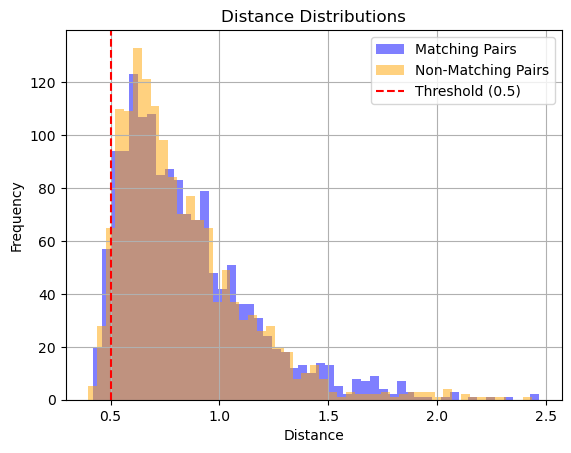

Matching Pairs: Mean = 0.8504, Std = 0.3094
Non-Matching Pairs: Mean = 0.8269, Std = 0.2908

Epoch 20/50 - Training Loss: 0.4558 - Validation Loss: 0.2047 - Accuracy: 0.5037 - Precision: 0.5401 - Recall: 0.0493 - F1 Score: 0.0904 - Time: 25.23 - Lr: 3.00e-05
New best model with Loss: 0.2047 at epoch 20
sum(all_preds)=390.0


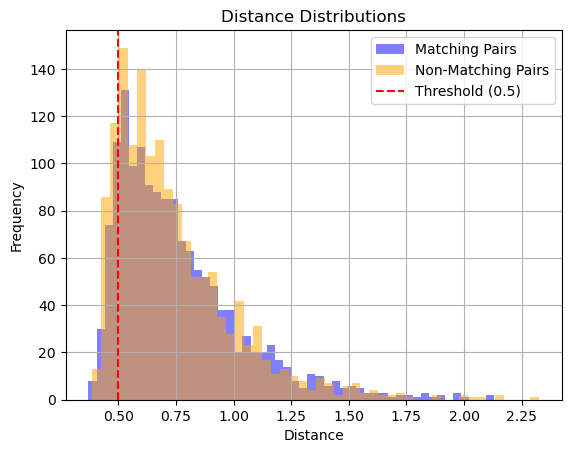

Matching Pairs: Mean = 0.7603, Std = 0.2771
Non-Matching Pairs: Mean = 0.7378, Std = 0.2661

Epoch 21/50 - Training Loss: 0.4192 - Validation Loss: 0.1637 - Accuracy: 0.4880 - Precision: 0.4538 - Recall: 0.1180 - F1 Score: 0.1873 - Time: 26.09 - Lr: 2.95e-05
New best model with Loss: 0.1637 at epoch 21
sum(all_preds)=678.0


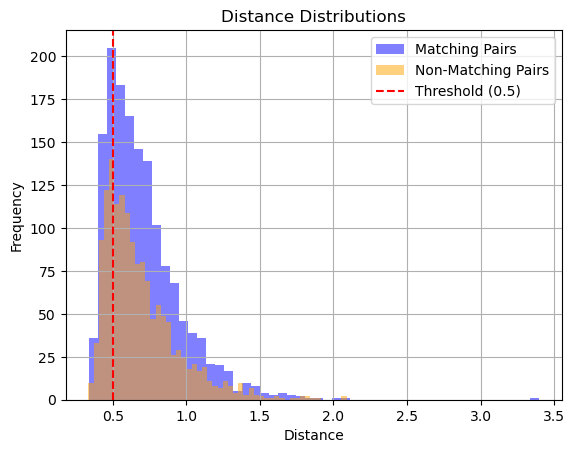

Matching Pairs: Mean = 0.7086, Std = 0.2648
Non-Matching Pairs: Mean = 0.6871, Std = 0.2523

Epoch 22/50 - Training Loss: 0.3578 - Validation Loss: 0.1430 - Accuracy: 0.4887 - Precision: 0.4749 - Recall: 0.2147 - F1 Score: 0.2957 - Time: 25.29 - Lr: 2.81e-05
New best model with Loss: 0.1430 at epoch 22
sum(all_preds)=1057.0


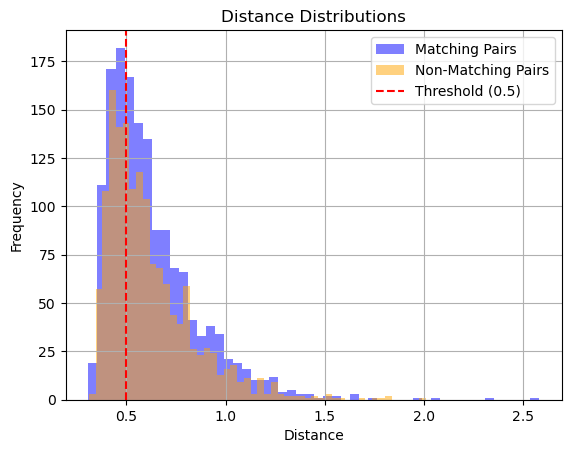

Matching Pairs: Mean = 0.6303, Std = 0.2372
Non-Matching Pairs: Mean = 0.6168, Std = 0.2219

Epoch 23/50 - Training Loss: 0.3029 - Validation Loss: 0.1134 - Accuracy: 0.4930 - Precision: 0.4901 - Recall: 0.3453 - F1 Score: 0.4052 - Time: 24.96 - Lr: 2.59e-05
New best model with Loss: 0.1134 at epoch 23
sum(all_preds)=1482.0


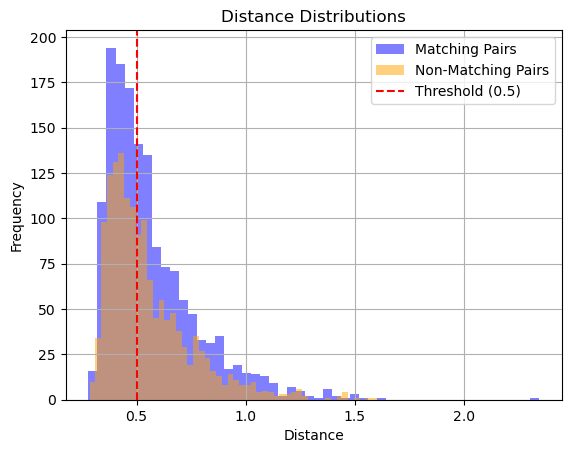

Matching Pairs: Mean = 0.5687, Std = 0.2157
Non-Matching Pairs: Mean = 0.5528, Std = 0.1991

Epoch 24/50 - Training Loss: 0.2481 - Validation Loss: 0.0925 - Accuracy: 0.4867 - Precision: 0.4865 - Recall: 0.4807 - F1 Score: 0.4836 - Time: 24.80 - Lr: 2.31e-05
New best model with Loss: 0.0925 at epoch 24
sum(all_preds)=1848.0


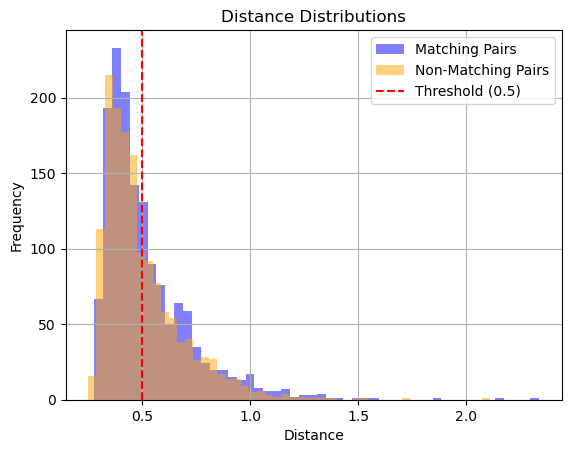

Matching Pairs: Mean = 0.5224, Std = 0.2100
Non-Matching Pairs: Mean = 0.5014, Std = 0.1896

Epoch 25/50 - Training Loss: 0.2028 - Validation Loss: 0.0793 - Accuracy: 0.4820 - Precision: 0.4854 - Recall: 0.5980 - F1 Score: 0.5358 - Time: 25.11 - Lr: 2.00e-05
New best model with Loss: 0.0793 at epoch 25
sum(all_preds)=2027.0


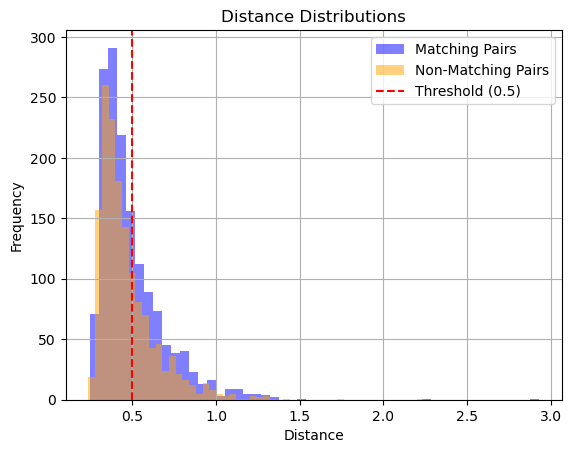

Matching Pairs: Mean = 0.4940, Std = 0.2053
Non-Matching Pairs: Mean = 0.4689, Std = 0.1802

Epoch 26/50 - Training Loss: 0.1694 - Validation Loss: 0.0715 - Accuracy: 0.4770 - Precision: 0.4830 - Recall: 0.6527 - F1 Score: 0.5551 - Time: 24.62 - Lr: 1.69e-05
New best model with Loss: 0.0715 at epoch 26
sum(all_preds)=2195.0


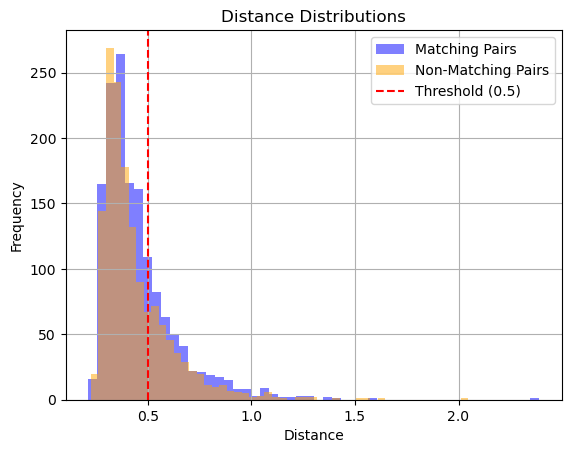

Matching Pairs: Mean = 0.4587, Std = 0.1866
Non-Matching Pairs: Mean = 0.4425, Std = 0.1768

Epoch 27/50 - Training Loss: 0.1451 - Validation Loss: 0.0613 - Accuracy: 0.4890 - Precision: 0.4925 - Recall: 0.7207 - F1 Score: 0.5851 - Time: 24.62 - Lr: 1.41e-05
New best model with Loss: 0.0613 at epoch 27
sum(all_preds)=2315.0


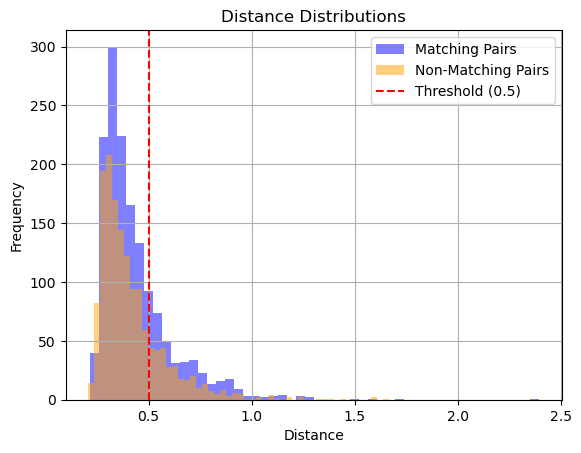

Matching Pairs: Mean = 0.4364, Std = 0.1830
Non-Matching Pairs: Mean = 0.4198, Std = 0.1695

Epoch 28/50 - Training Loss: 0.1254 - Validation Loss: 0.0560 - Accuracy: 0.4843 - Precision: 0.4898 - Recall: 0.7560 - F1 Score: 0.5945 - Time: 25.01 - Lr: 1.19e-05
New best model with Loss: 0.0560 at epoch 28
sum(all_preds)=2407.0


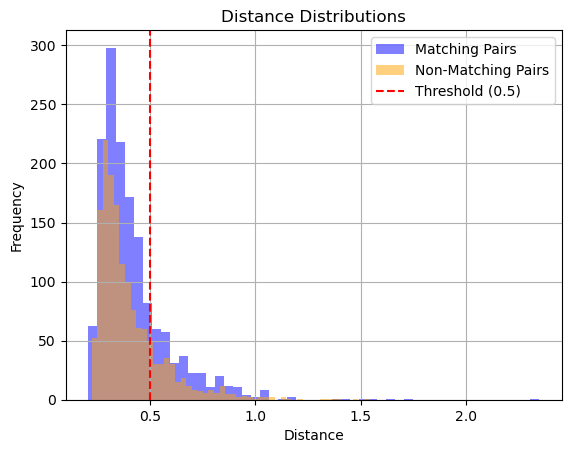

Matching Pairs: Mean = 0.4205, Std = 0.1806
Non-Matching Pairs: Mean = 0.4003, Std = 0.1623

Epoch 29/50 - Training Loss: 0.1111 - Validation Loss: 0.0524 - Accuracy: 0.4837 - Precision: 0.4898 - Recall: 0.7860 - F1 Score: 0.6035 - Time: 24.73 - Lr: 1.05e-05
New best model with Loss: 0.0524 at epoch 29
sum(all_preds)=2446.0


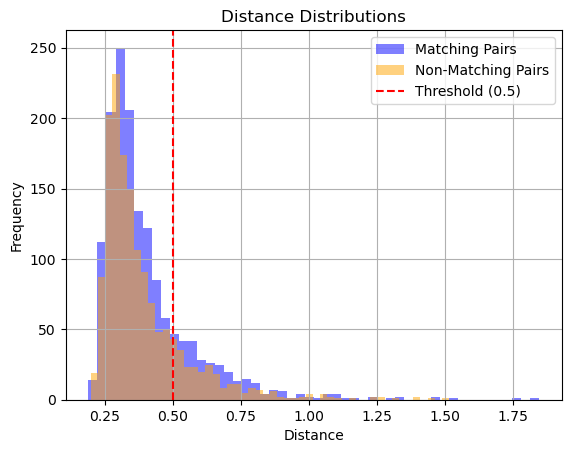

Matching Pairs: Mean = 0.4071, Std = 0.1774
Non-Matching Pairs: Mean = 0.3902, Std = 0.1637

Epoch 30/50 - Training Loss: 0.0998 - Validation Loss: 0.0493 - Accuracy: 0.4853 - Precision: 0.4910 - Recall: 0.8007 - F1 Score: 0.6087 - Time: 24.69 - Lr: 3.00e-05
New best model with Loss: 0.0493 at epoch 30
sum(all_preds)=2608.0


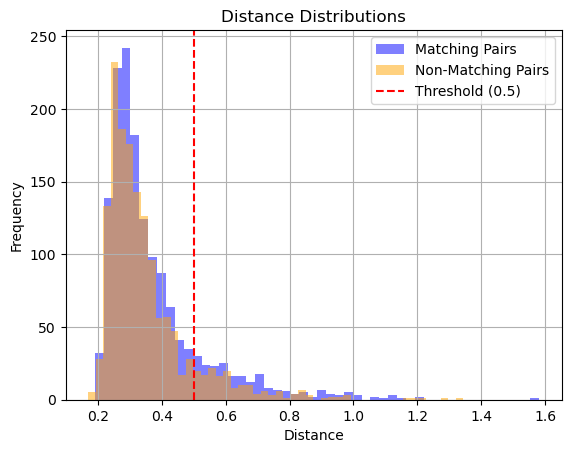

Matching Pairs: Mean = 0.3708, Std = 0.1590
Non-Matching Pairs: Mean = 0.3493, Std = 0.1367

Epoch 31/50 - Training Loss: 0.0826 - Validation Loss: 0.0407 - Accuracy: 0.4813 - Precision: 0.4893 - Recall: 0.8507 - F1 Score: 0.6212 - Time: 24.77 - Lr: 2.95e-05
New best model with Loss: 0.0407 at epoch 31
sum(all_preds)=2698.0


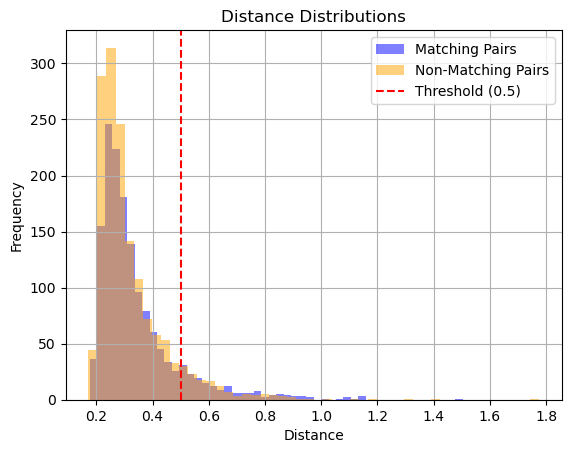

Matching Pairs: Mean = 0.3410, Std = 0.1457
Non-Matching Pairs: Mean = 0.3227, Std = 0.1349

Epoch 32/50 - Training Loss: 0.0619 - Validation Loss: 0.0344 - Accuracy: 0.4880 - Precision: 0.4933 - Recall: 0.8873 - F1 Score: 0.6341 - Time: 24.95 - Lr: 2.81e-05
New best model with Loss: 0.0344 at epoch 32
sum(all_preds)=2800.0


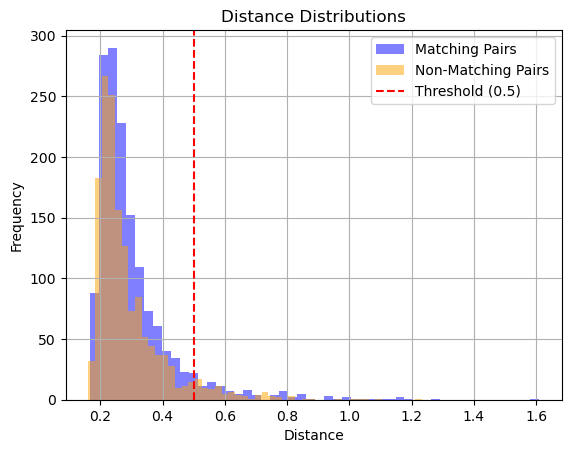

Matching Pairs: Mean = 0.3050, Std = 0.1394
Non-Matching Pairs: Mean = 0.2896, Std = 0.1183

Epoch 33/50 - Training Loss: 0.0464 - Validation Loss: 0.0283 - Accuracy: 0.4953 - Precision: 0.4975 - Recall: 0.9287 - F1 Score: 0.6479 - Time: 24.88 - Lr: 2.59e-05
New best model with Loss: 0.0283 at epoch 33
sum(all_preds)=2885.0


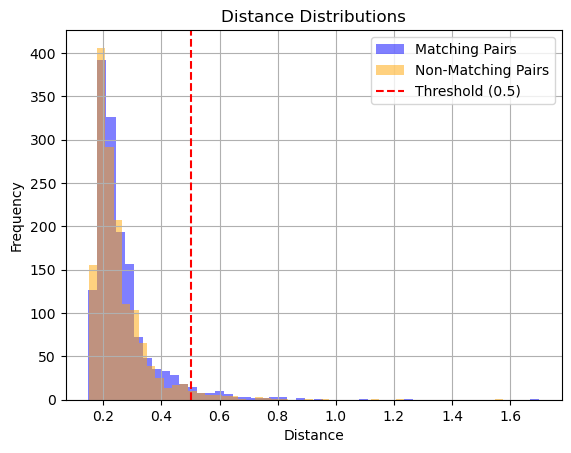

Matching Pairs: Mean = 0.2665, Std = 0.1155
Non-Matching Pairs: Mean = 0.2556, Std = 0.1055

Epoch 34/50 - Training Loss: 0.0349 - Validation Loss: 0.0215 - Accuracy: 0.4943 - Precision: 0.4971 - Recall: 0.9560 - F1 Score: 0.6540 - Time: 24.78 - Lr: 2.31e-05
New best model with Loss: 0.0215 at epoch 34
sum(all_preds)=2930.0


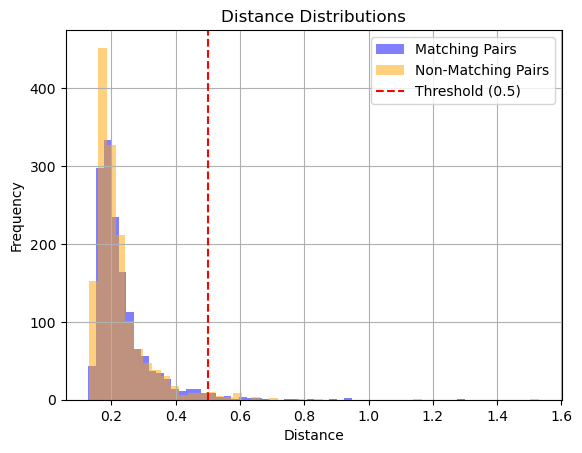

Matching Pairs: Mean = 0.2348, Std = 0.0959
Non-Matching Pairs: Mean = 0.2253, Std = 0.0931

Epoch 35/50 - Training Loss: 0.0272 - Validation Loss: 0.0169 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.9767 - F1 Score: 0.6614 - Time: 24.71 - Lr: 2.00e-05
New best model with Loss: 0.0169 at epoch 35
sum(all_preds)=2958.0


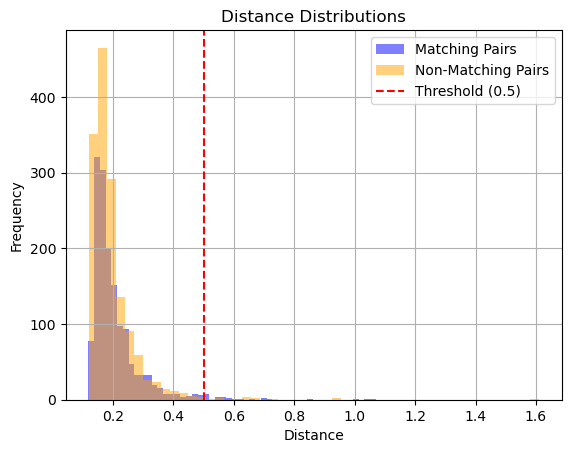

Matching Pairs: Mean = 0.2080, Std = 0.0897
Non-Matching Pairs: Mean = 0.1982, Std = 0.0841

Epoch 36/50 - Training Loss: 0.0216 - Validation Loss: 0.0143 - Accuracy: 0.4960 - Precision: 0.4980 - Recall: 0.9820 - F1 Score: 0.6608 - Time: 24.58 - Lr: 1.69e-05
New best model with Loss: 0.0143 at epoch 36
sum(all_preds)=2982.0


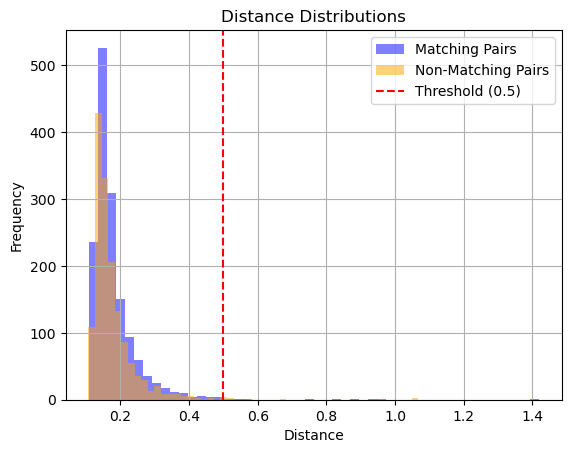

Matching Pairs: Mean = 0.1828, Std = 0.0790
Non-Matching Pairs: Mean = 0.1763, Std = 0.0706

Epoch 37/50 - Training Loss: 0.0178 - Validation Loss: 0.0120 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.9940 - F1 Score: 0.6653 - Time: 24.83 - Lr: 1.41e-05
New best model with Loss: 0.0120 at epoch 37
sum(all_preds)=2986.0


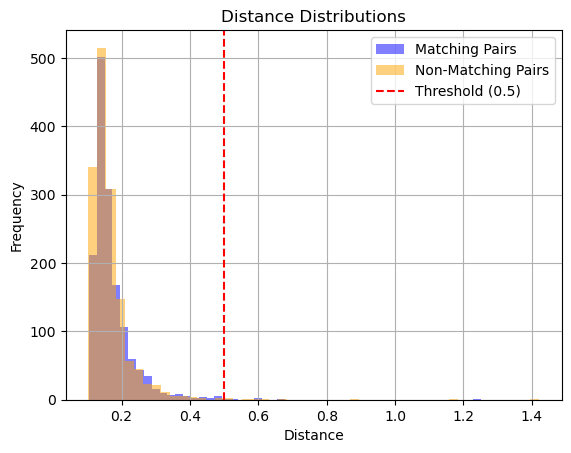

Matching Pairs: Mean = 0.1718, Std = 0.0668
Non-Matching Pairs: Mean = 0.1665, Std = 0.0721

Epoch 38/50 - Training Loss: 0.0155 - Validation Loss: 0.0109 - Accuracy: 0.5013 - Precision: 0.5007 - Recall: 0.9967 - F1 Score: 0.6665 - Time: 25.36 - Lr: 1.19e-05
New best model with Loss: 0.0109 at epoch 38
sum(all_preds)=2990.0


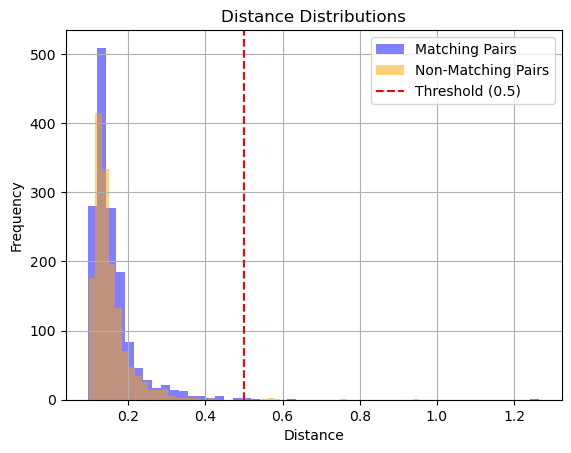

Matching Pairs: Mean = 0.1598, Std = 0.0650
Non-Matching Pairs: Mean = 0.1542, Std = 0.0563

Epoch 39/50 - Training Loss: 0.0138 - Validation Loss: 0.0103 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 0.9973 - F1 Score: 0.6664 - Time: 25.18 - Lr: 1.05e-05
New best model with Loss: 0.0103 at epoch 39
sum(all_preds)=2986.0


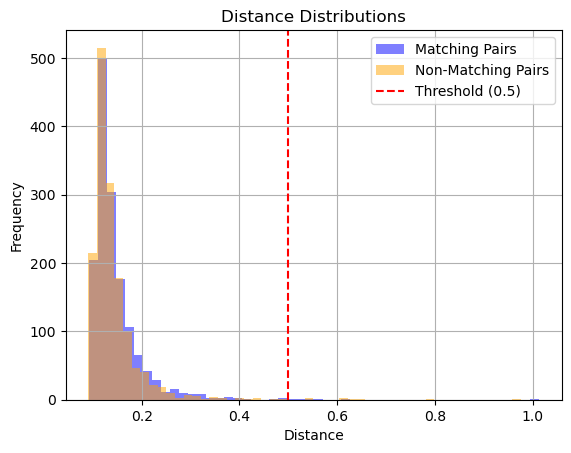

Matching Pairs: Mean = 0.1475, Std = 0.0573
Non-Matching Pairs: Mean = 0.1425, Std = 0.0583

Epoch 40/50 - Training Loss: 0.0123 - Validation Loss: 0.0097 - Accuracy: 0.5007 - Precision: 0.5003 - Recall: 0.9960 - F1 Score: 0.6661 - Time: 24.95 - Lr: 3.00e-05
New best model with Loss: 0.0097 at epoch 40
sum(all_preds)=2994.0


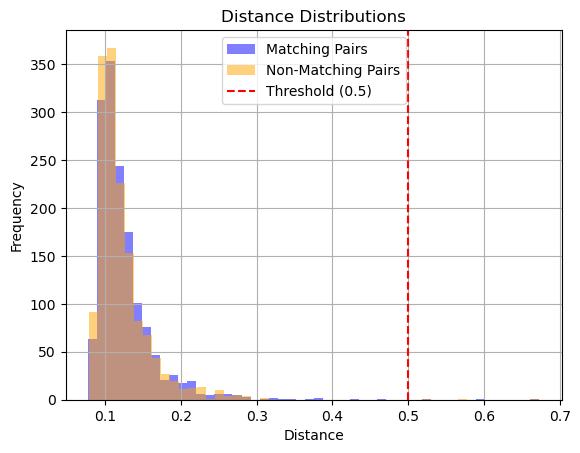

Matching Pairs: Mean = 0.1260, Std = 0.0441
Non-Matching Pairs: Mean = 0.1225, Std = 0.0397

Epoch 41/50 - Training Loss: 0.0109 - Validation Loss: 0.0089 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.9980 - F1 Score: 0.6662 - Time: 24.93 - Lr: 2.95e-05
New best model with Loss: 0.0089 at epoch 41
sum(all_preds)=2997.0


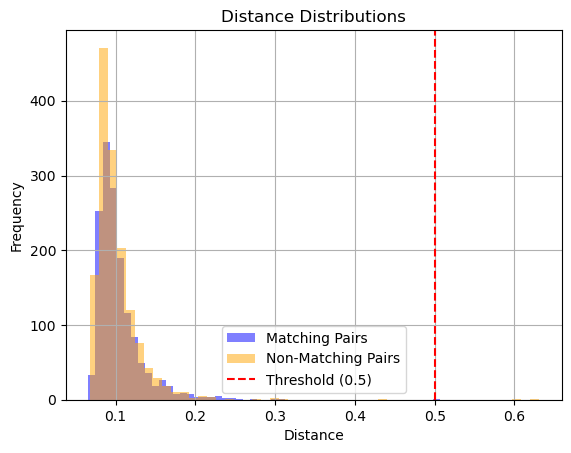

Matching Pairs: Mean = 0.1038, Std = 0.0299
Non-Matching Pairs: Mean = 0.1018, Std = 0.0331

Epoch 42/50 - Training Loss: 0.0094 - Validation Loss: 0.0086 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 0.9993 - F1 Score: 0.6667 - Time: 25.45 - Lr: 2.81e-05
New best model with Loss: 0.0086 at epoch 42
sum(all_preds)=3000.0


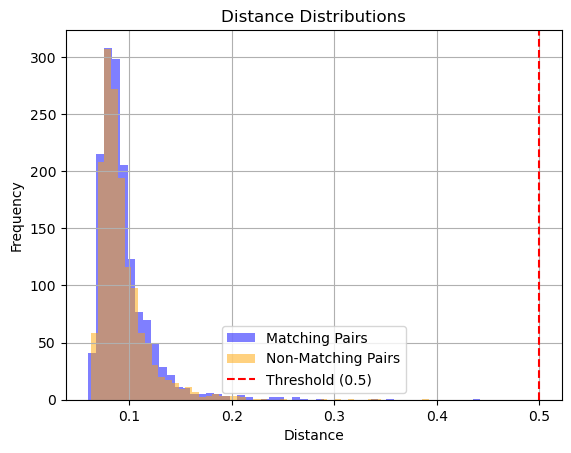

Matching Pairs: Mean = 0.0947, Std = 0.0287
Non-Matching Pairs: Mean = 0.0934, Std = 0.0274

Epoch 43/50 - Training Loss: 0.0088 - Validation Loss: 0.0088 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 25.52 - Lr: 2.59e-05
Validation loss did not improve significantly
sum(all_preds)=2999.0


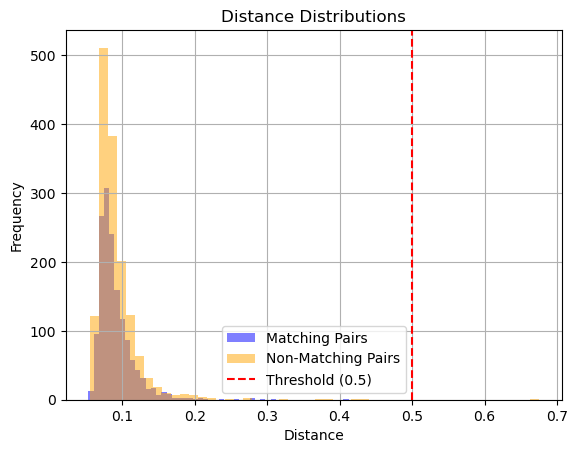

Matching Pairs: Mean = 0.0904, Std = 0.0263
Non-Matching Pairs: Mean = 0.0917, Std = 0.0339

Epoch 44/50 - Training Loss: 0.0085 - Validation Loss: 0.0087 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 1.0000 - F1 Score: 0.6668 - Time: 25.51 - Lr: 2.31e-05
Validation loss did not improve significantly
sum(all_preds)=3000.0


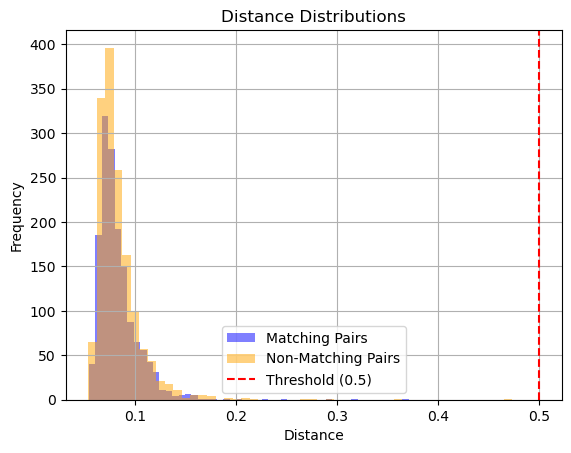

Matching Pairs: Mean = 0.0837, Std = 0.0222
Non-Matching Pairs: Mean = 0.0840, Std = 0.0251

Epoch 45/50 - Training Loss: 0.0082 - Validation Loss: 0.0089 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 24.56 - Lr: 2.00e-05
Validation loss did not improve significantly
sum(all_preds)=2998.0


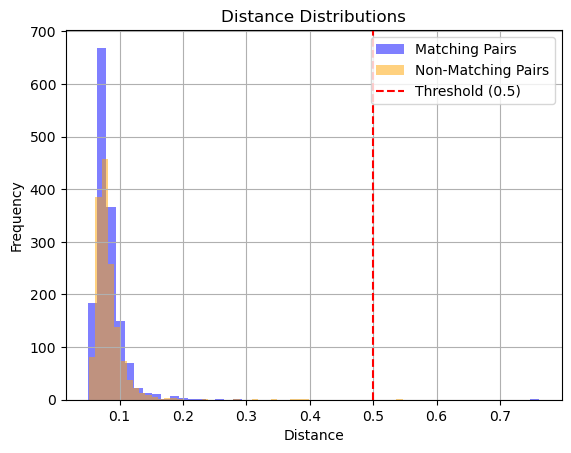

Matching Pairs: Mean = 0.0828, Std = 0.0283
Non-Matching Pairs: Mean = 0.0832, Std = 0.0283

Epoch 46/50 - Training Loss: 0.0081 - Validation Loss: 0.0090 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.9993 - F1 Score: 0.6665 - Time: 25.19 - Lr: 1.69e-05
Validation loss did not improve significantly
sum(all_preds)=2999.0


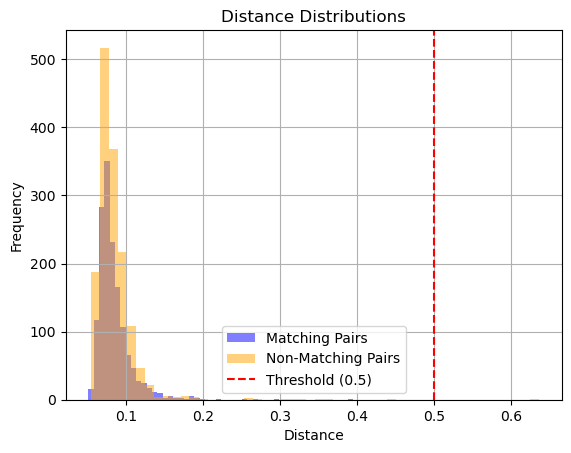

Matching Pairs: Mean = 0.0840, Std = 0.0236
Non-Matching Pairs: Mean = 0.0849, Std = 0.0301

Epoch 47/50 - Training Loss: 0.0082 - Validation Loss: 0.0089 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 1.0000 - F1 Score: 0.6668 - Time: 25.22 - Lr: 1.41e-05
Validation loss did not improve significantly
sum(all_preds)=3000.0


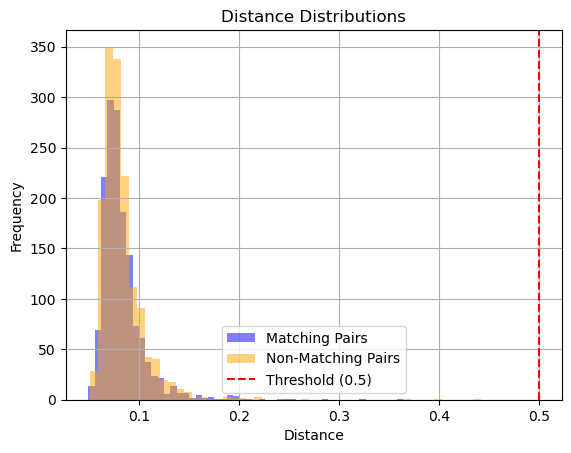

Matching Pairs: Mean = 0.0831, Std = 0.0247
Non-Matching Pairs: Mean = 0.0835, Std = 0.0260

Epoch 48/50 - Training Loss: 0.0081 - Validation Loss: 0.0090 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 1.0000 - F1 Score: 0.6667 - Time: 25.04 - Lr: 1.19e-05
Validation loss did not improve significantly
sum(all_preds)=2999.0


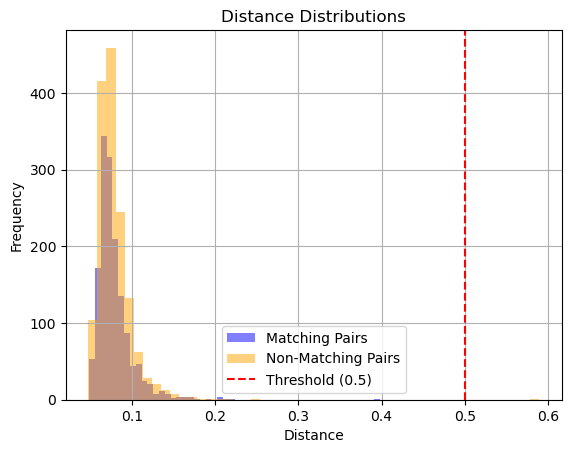

Matching Pairs: Mean = 0.0789, Std = 0.0218
Non-Matching Pairs: Mean = 0.0795, Std = 0.0238

Epoch 49/50 - Training Loss: 0.0081 - Validation Loss: 0.0091 - Accuracy: 0.5003 - Precision: 0.5002 - Recall: 1.0000 - F1 Score: 0.6668 - Time: 26.22 - Lr: 1.05e-05
Validation loss did not improve significantly
sum(all_preds)=2998.0


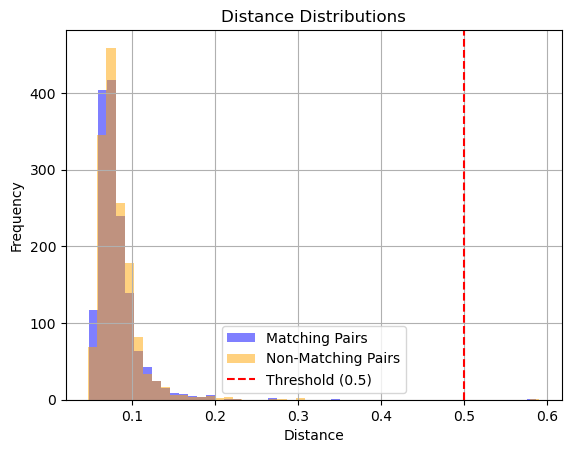

Matching Pairs: Mean = 0.0813, Std = 0.0274
Non-Matching Pairs: Mean = 0.0824, Std = 0.0279

Epoch 50/50 - Training Loss: 0.0080 - Validation Loss: 0.0090 - Accuracy: 0.5000 - Precision: 0.5000 - Recall: 0.9993 - F1 Score: 0.6665 - Time: 25.50 - Lr: 3.00e-05
Validation loss did not improve significantly
Training finished!


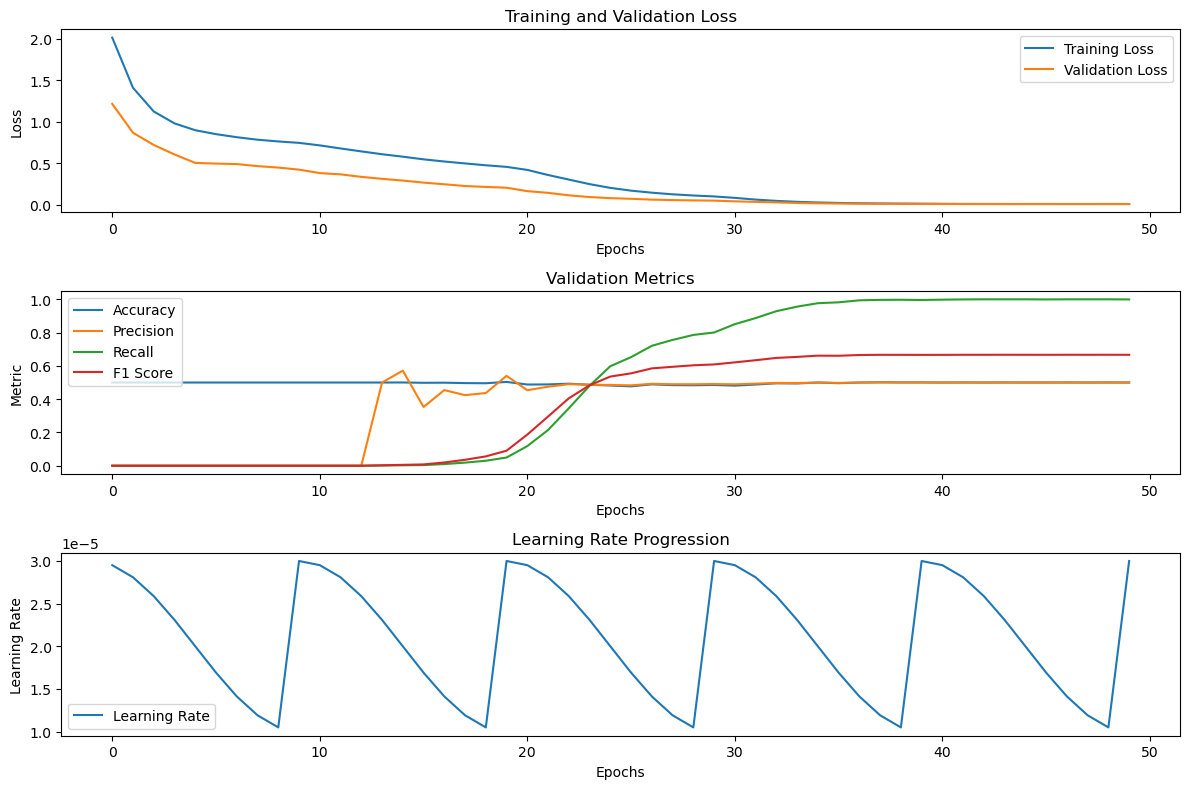

In [24]:
best_text_model, best_image_model = training_method(criterion, optimizer, scheduler, num_epochs=50, train_loader=train_dataloader, val_loader=val_dataloader)

In [ ]:
def make_submission(test_loader, text_model, image_model):
    image_model.eval()
    text_model.eval()
    ids = []
    predictions = []

    with torch.no_grad():
        for batch in tqdm(test_loader):
            images = batch['images'].to(device)
            captions = batch['captions'].to(device)
            id = batch['id']

            img_features = image_model(images)
            txt_features = text_model(captions)
            # Compute distances and predictions
            distances = torch.norm(img_features - txt_features, p=2, dim=1)
            preds = (distances < margin).int()

            ids.extend(id)
            predictions.extend(preds.cpu().tolist())
    df = pd.DataFrame({'id': ids, 'label': predictions}) 
    df.to_csv('submission5.csv', index=False) 

In [ ]:
# # LOAD MODEL FROM PATH
# model_config = {
# ADD
# }
# model = ImageTextClassifier(**model_config)
# model_path = "vocab_size=3733+embedding_dim=128+num_filters=128+filter_sizes=[3, 4, 5, 6, 7, 8]+seq_len=53+cnn_text_drop_value=0.5+cnn_dropout_value=0.4+head_dropout_value=0.5+num_classes=1+eval_loss=0.6202353974606128.pt"
# model.load_state_dict(torch.load(model_path, weights_only=True))
# model.to(device)

In [ ]:
make_submission(test_dataloader, best_text_model, best_image_model)

In [247]:
import torch
from torch import nn
import torch.nn.functional as F


class CLIPModel(nn.Module):
    def __init__(self, temperature=0.07, image_embedding=256, text_embedding=256):
        super().__init__()
        self.image_encoder = CNN(0.25)
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = nn.Parameter(torch.ones([]) * temperature)  # Learnable temperature

    def forward(self, batch):
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])  # [batch_size, image_embedding]
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )  # [batch_size, text_embedding]
        
        print(image_features.shape)
        print(text_features.shape)
        # Projecting Features to Latent Space
        image_embeddings = self.image_projection(image_features)  # [batch_size, projection_dim]
        text_embeddings = self.text_projection(text_features)    # [batch_size, projection_dim]
        
        # Normalize Embeddings
        image_embeddings = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings = F.normalize(text_embeddings, p=2, dim=-1)
        
        # Similarity Scores
        logits = (text_embeddings @ image_embeddings.T) / self.temperature  # [batch_size, batch_size]
        images_similarity = image_embeddings @ image_embeddings.T  # [batch_size, batch_size]
        texts_similarity = text_embeddings @ text_embeddings.T    # [batch_size, batch_size]
        
        # Targets
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature.detach(), dim=-1
        )  # Detach temperature to prevent gradients from flowing
        
        # Loss Calculation
        texts_loss = cross_entropy(logits, targets, reduction='none')  # [batch_size]
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')  # [batch_size]
        loss = (images_loss + texts_loss) / 2.0  # Average the losses
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()
    else:
        raise ValueError(f"Invalid reduction mode: {reduction}")


# Dummy Components for Testing
class ImageEncoder(nn.Module):
    def forward(self, x):
        return torch.randn(x.size(0), 128)  # Example dummy output


class TextEncoder(nn.Module):
    def forward(self, input_ids, attention_mask):
        return torch.randn(input_ids.size(0), 256)  # Example dummy output


class ProjectionHead(nn.Module):
    def __init__(self, embedding_dim):
        super().__init__()
        self.fc = nn.Linear(embedding_dim, embedding_dim)

    def forward(self, x):
        return self.fc(x)


if __name__ == '__main__':
    images = torch.randn(8, 3, 100, 100)
    input_ids = torch.randint(5, 300, size=(8, 25))
    attention_mask = torch.ones(8, 25)
    batch = {
        'image': images,
        'input_ids': input_ids,
        'attention_mask': attention_mask
    }

    CLIP = CLIPModel()
    loss = CLIP(batch)
    print(f"Loss: {loss.item():.4f}")


torch.Size([8, 256])
torch.Size([8, 256])
Loss: 2.3167


In [ ]:

def hyperparameter_tuning(vocab_size, max_len, train_loader, val_loader, param_grid, training_method, num_epochs=200):
    # Create all combinations of hyperparameters
    keys, values = zip(*param_grid.items())
    param_combinations = [dict(zip(keys, v)) for v in product(*values)]

    for params in tqdm(param_combinations):
        print(f"Testing configuration: {params}")

        try:
            # Update model configuration
            model_config = {
                "vocab_size": vocab_size,
                "embedding_dim": params["embedding_dim"],
                "num_filters": params["num_filters"],
                "filter_sizes": params["filter_sizes"],
                "seq_len": max_len,
                "cnn_text_drop_value": params["cnn_text_drop_value"],
                "cnn_dropout_value": params["cnn_dropout_value"],
                "head_dropout_value": params["head_dropout_value"],
            }

            # Initialize model
            model = ImageTextClassifier(**model_config)
            model.to(device)
            model.apply(initialize_weights)

            # Define criterion, optimizer, and scheduler
            criterion = nn.BCEWithLogitsLoss()
            optimizer = optim.AdamW(
                model.parameters(),
                lr=params["lr"],
                weight_decay=params["weight_decay"]
            )
            scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(
                optimizer,
                T_0=params["T_0"],
                eta_min=params["eta_min"],
            )

            # Train the model
            training_method(
                model, criterion, optimizer, scheduler,
                num_epochs=num_epochs,
                train_loader=train_loader,
                val_loader=val_loader
            )
            print(f"Completed configuration: {params}")

        except RuntimeError as e:
            print(f"Error with configuration: {params}")
            print(f"Error message: {str(e)}")

        finally:
            # Reset GPU memory
            print("Resetting GPU memory...")
            torch.cuda.empty_cache()
            gc.collect()

In [ ]:
param_grid = {
    "embedding_dim": [128],
    "num_filters": [16],
    "filter_sizes": [[3, 4, 5], [3, 4, 5, 6, 7, 8, 9]],
    "head_dropout_value": [0.5],
    "cnn_text_drop_value": [0.5],
    "cnn_dropout_value": [0.5],
    "lr": [1e-5, 1e-4, 5e-4, 1e-3, 5e-3],  # Learning rate candidates
    "weight_decay": [1e-6, 1e-5, 1e-4, 1e-3],  # Weight decay candidates
    "T_0": [10],  # Number of epochs for the first cycle
    "T_mult": [1],  # Cycle multiplier
    "eta_min": [1e-6, 1e-5, 1e-4],  # Minimum learning rate
}

total_combinations = math.prod(len(values) for values in param_grid.values())
print(f"Total combinations: {total_combinations}")

time_per_epoch = 23  # seconds
num_epochs = 100  # epochs per configuration
total_time_seconds = total_combinations * time_per_epoch * num_epochs

# Convert to hours
total_time_hours = total_time_seconds / 3600
print(f"Total time to hyper tune: {total_time_hours} hours")

In [ ]:
results = hyperparameter_tuning(
    vocab_size=len(vocab),
    max_len=max_len,
    train_loader=train_dataloader,
    val_loader=val_dataloader,
    param_grid=param_grid,
    training_method=training_method,
    num_epochs=100
)

In [ ]:
dir_models = os.listdir("./models")

In [ ]:
best_models = [path[:-3] for path in dir_models if path.endswith(".pt")]

In [ ]:
best_val_loss = [float(str(best_model.split("+")[-1:]).split("=")[1][:8]) for best_model in best_models]

In [ ]:
best_val_loss.sort()
best_val_loss[:100]